Тема курсовой работы: Оптимизация ансамблевых методов в машинном обучении для задачи прогнозирования оттока клиентов»

In [82]:
!pip install shap

In [83]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [84]:
import pandas as pd
import shap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.validation import check_X_y

In [85]:
# Загрузка данных
data = pd.read_csv('churn.csv')

In [86]:
# Предварительный анализ данных
print(data.head())
print(data.info())
print(data.describe())
print(data.isnull().sum())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

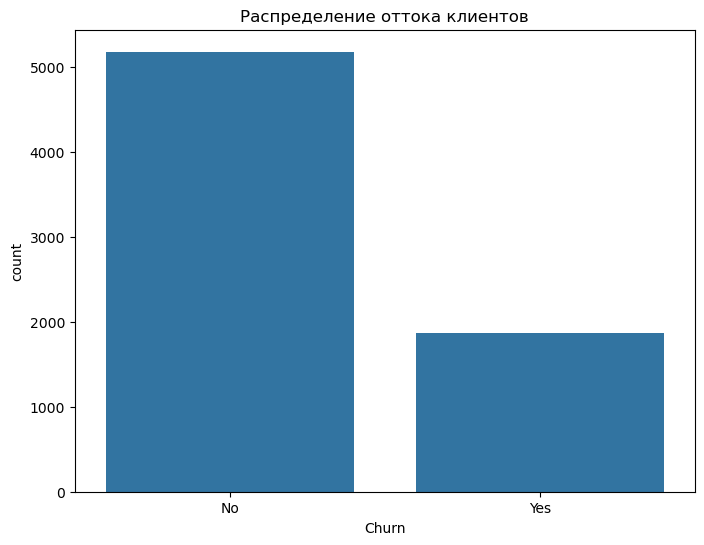

In [87]:
# Визуализация распределения целевой переменной
plt.figure(figsize=(8, 6))
sns.countplot(x='Churn', data=data)
plt.title('Распределение оттока клиентов')
plt.savefig('churn_distribution.png')
plt.show()

In [88]:
# Подготовка данных
# Удаление ненужных столбцов
data = data.drop(['customerID'], axis=1)

In [89]:
# Преобразование TotalCharges в числовой формат
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

In [90]:
# Разделение на признаки и целевую переменную
X = data.drop(['Churn'], axis=1)
y = data['Churn'].map({'Yes': 1, 'No': 0})

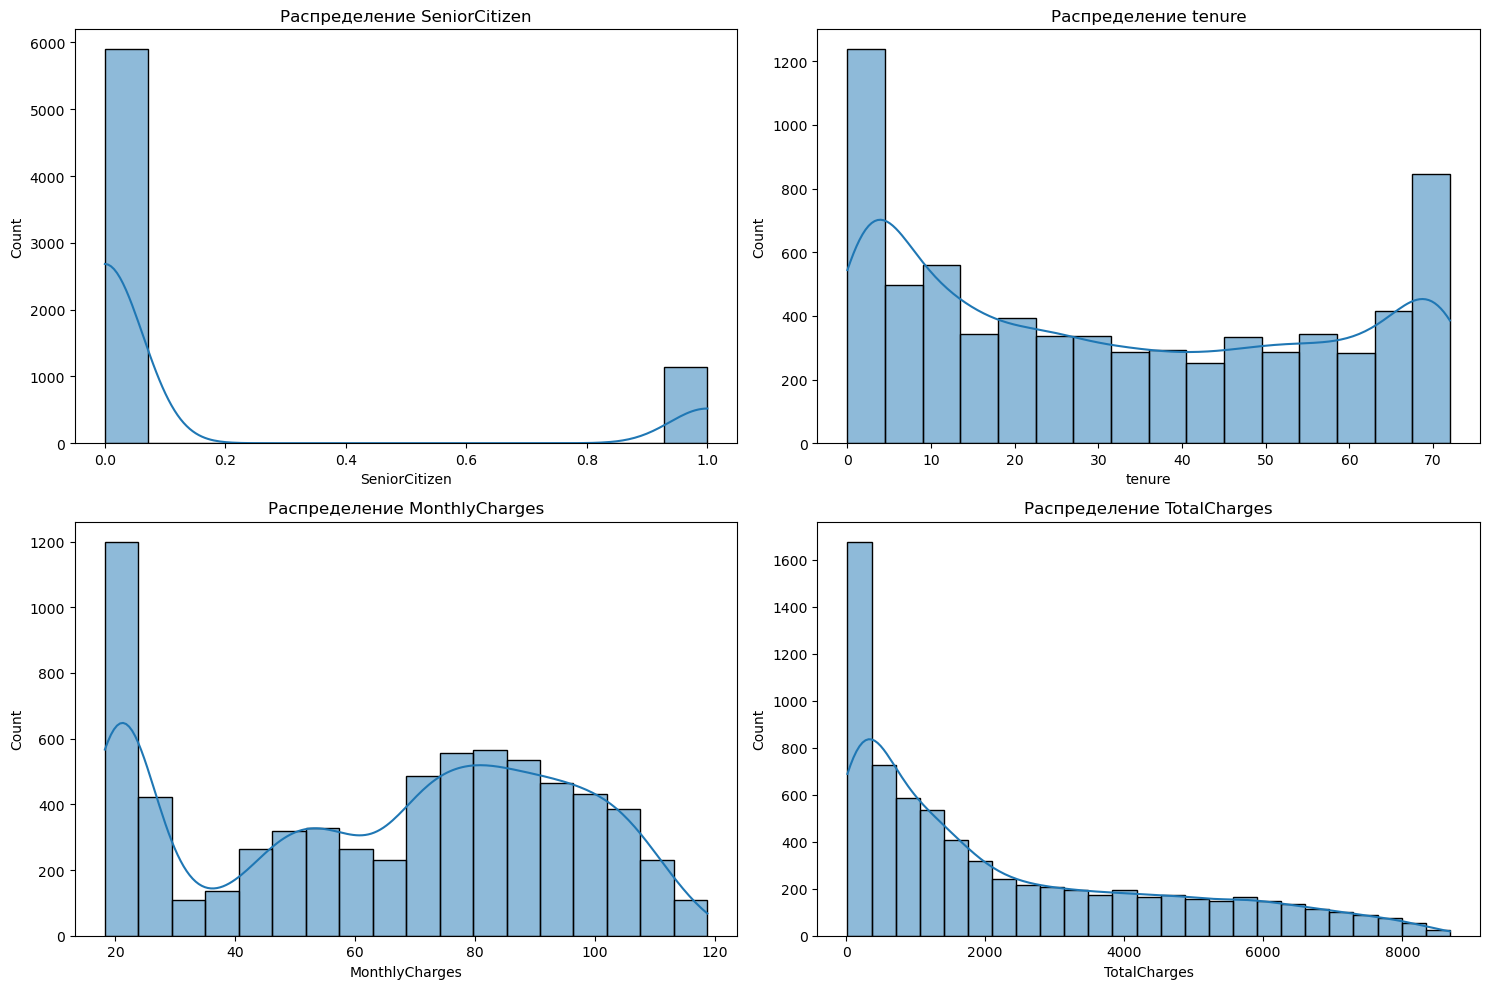

In [91]:
# Анализ распределения числовых признаков
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols):
    plt.subplot(2, 2, i+1)
    sns.histplot(data[col], kde=True)
    plt.title(f'Распределение {col}')
plt.tight_layout()
plt.savefig('numeric_features_distribution.png')
plt.show()

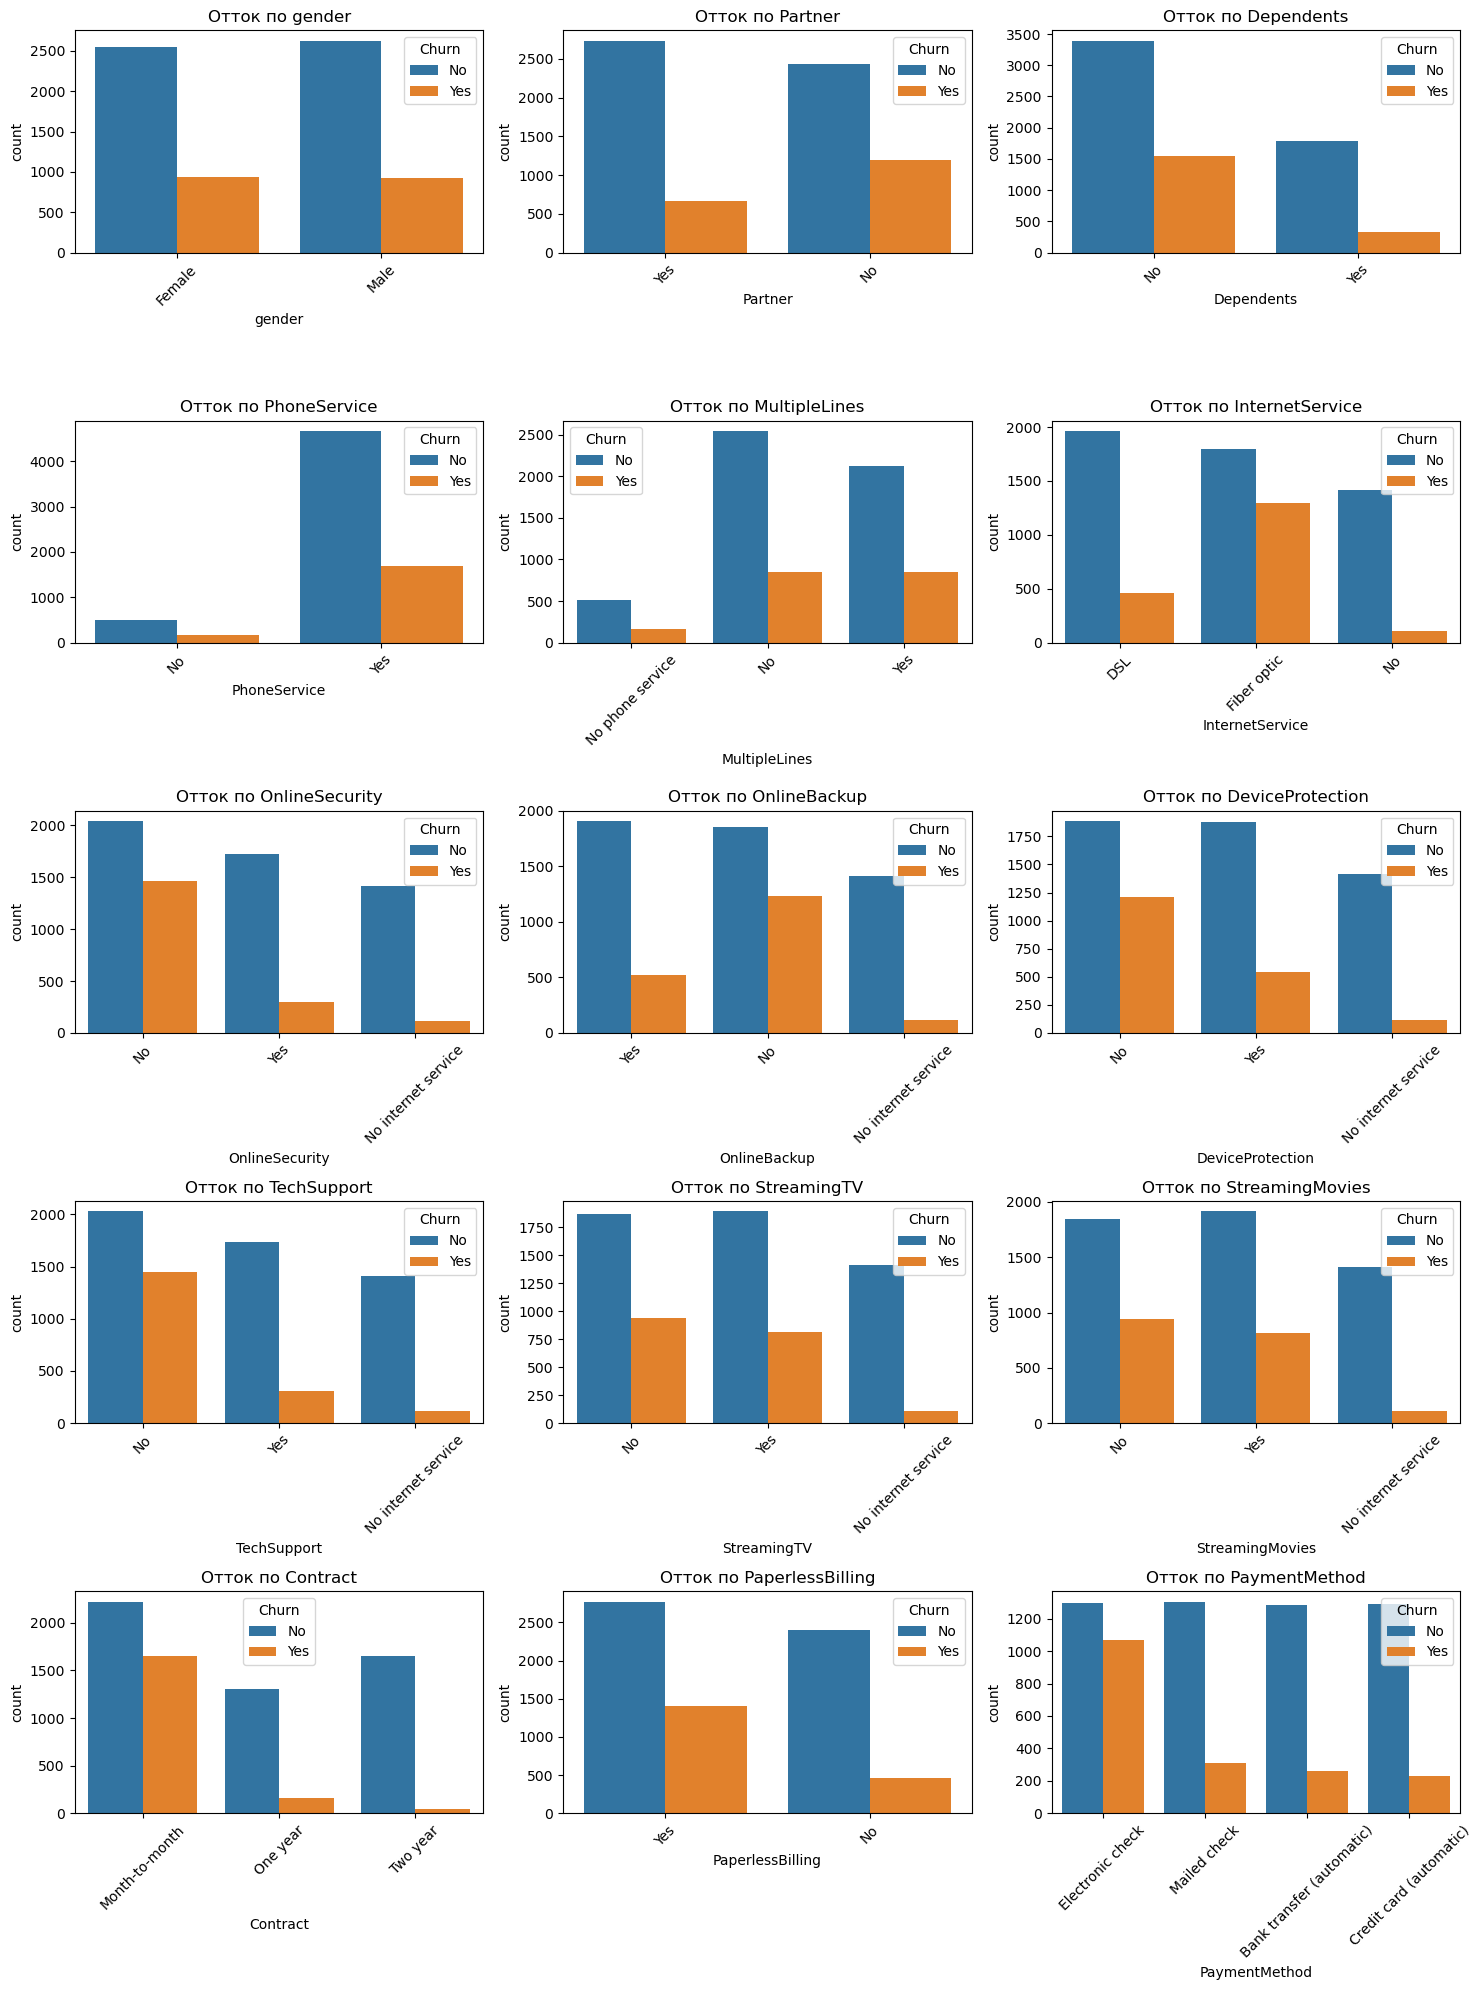

In [92]:
# Анализ категориальных признаков
plt.figure(figsize=(15, 20))
for i, col in enumerate(cat_cols):
    plt.subplot(5, 3, i+1)
    sns.countplot(x=col, hue='Churn', data=data)
    plt.title(f'Отток по {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('categorical_features_analysis.png')
plt.show()

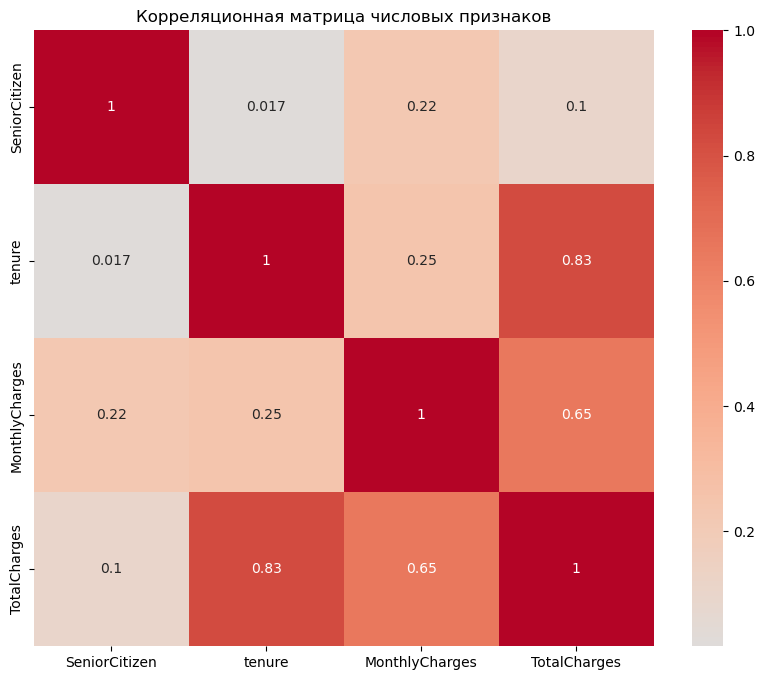

In [93]:
# Корреляционная матрица для числовых признаков
corr_matrix = data[num_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляционная матрица числовых признаков')
plt.savefig('correlation_matrix.png')
plt.show()

In [94]:
# Разделение категориальных и числовых признаков
cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns

In [95]:
# Создание пайплайна предобработки
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)])

In [96]:
# Применение SMOTE для балансировки классов
smote = SMOTE(random_state=42)

In [97]:
# Разделение данных на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [98]:
# Предобработка данных
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [99]:
# Применение SMOTE только к обучающим данным
X_train_res, y_train_res = smote.fit_resample(*check_X_y(X_train_preprocessed, y_train))

In [100]:
# Получение имен признаков после OneHot кодирования
cat_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_features = cat_encoder.get_feature_names_out(cat_cols)
all_features = np.concatenate([num_cols, cat_features])

In [101]:
# Функция для оценки моделей
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Метрики
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    
    # ROC кривая
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # PR кривая
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    
    # Визуализация
    plt.figure(figsize=(15, 5))
    
    # Матрица ошибок
    plt.subplot(1, 3, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    
    # ROC кривая
    plt.subplot(1, 3, 2)
    plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    
    # PR кривая
    plt.subplot(1, 3, 3)
    plt.plot(recall_curve, precision_curve, label=f'PR AUC = {pr_auc:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'{model.__class__.__name__}_metrics.png')
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc
    }

In [102]:
# Базовые модели
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0)
}

Evaluating Logistic Regression...


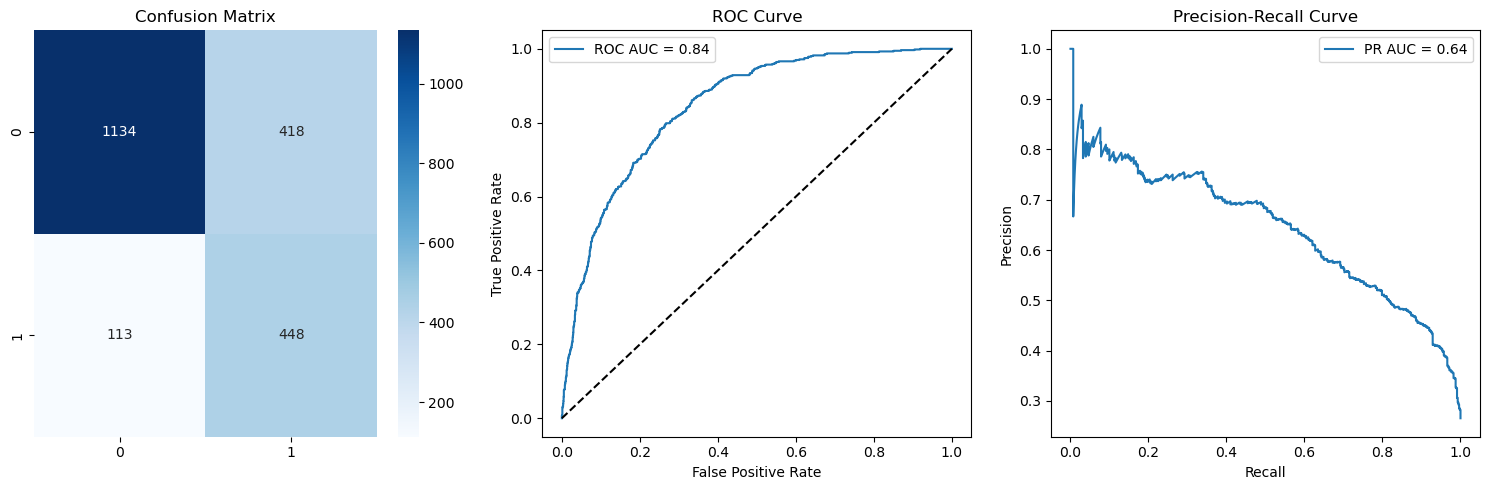

Evaluating Random Forest...


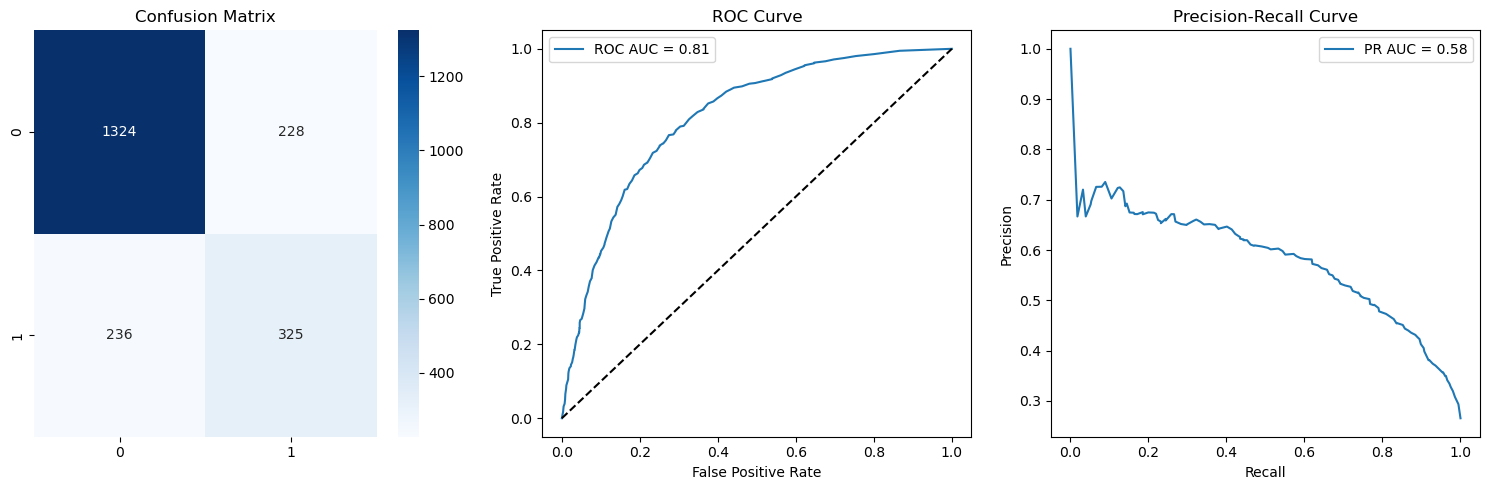

Evaluating Gradient Boosting...


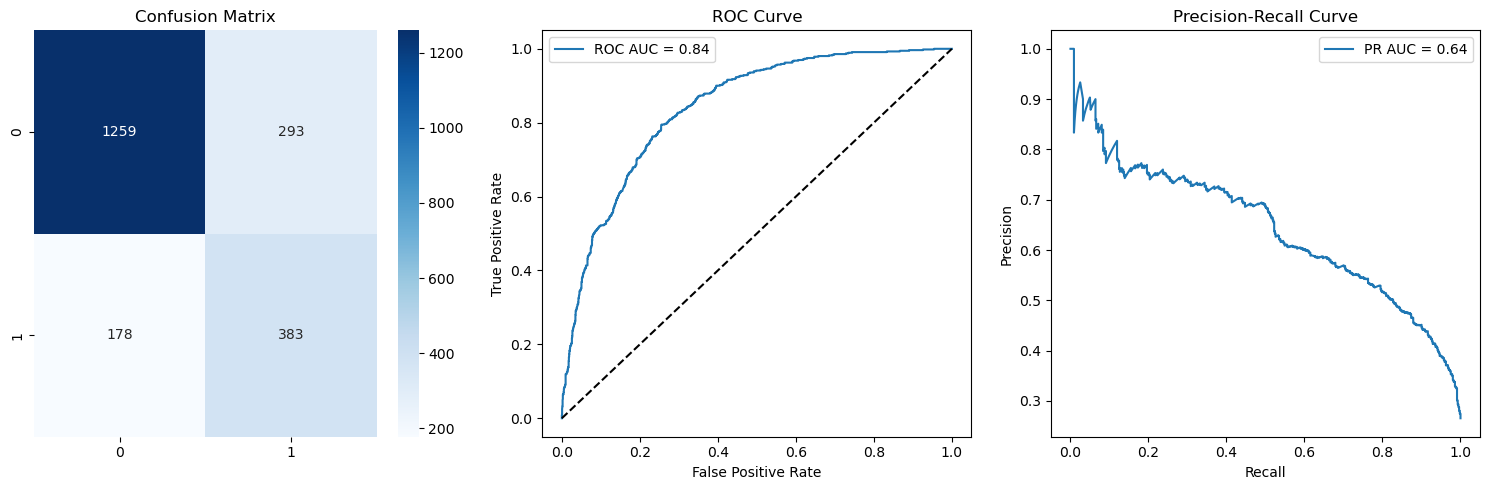

Evaluating XGBoost...


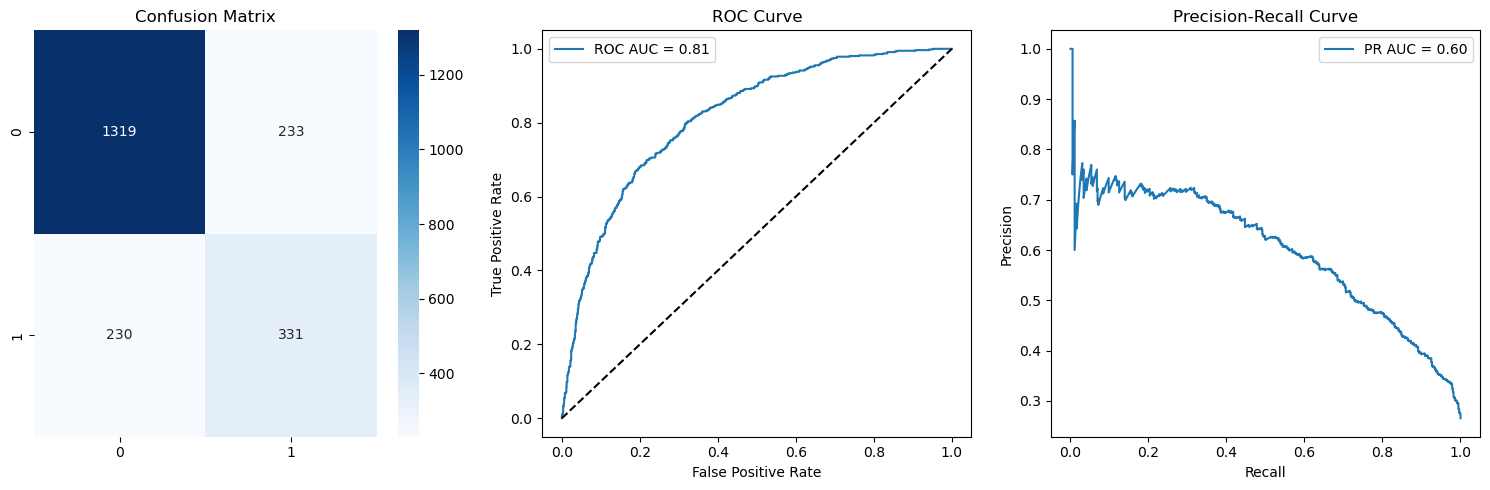

Evaluating LightGBM...


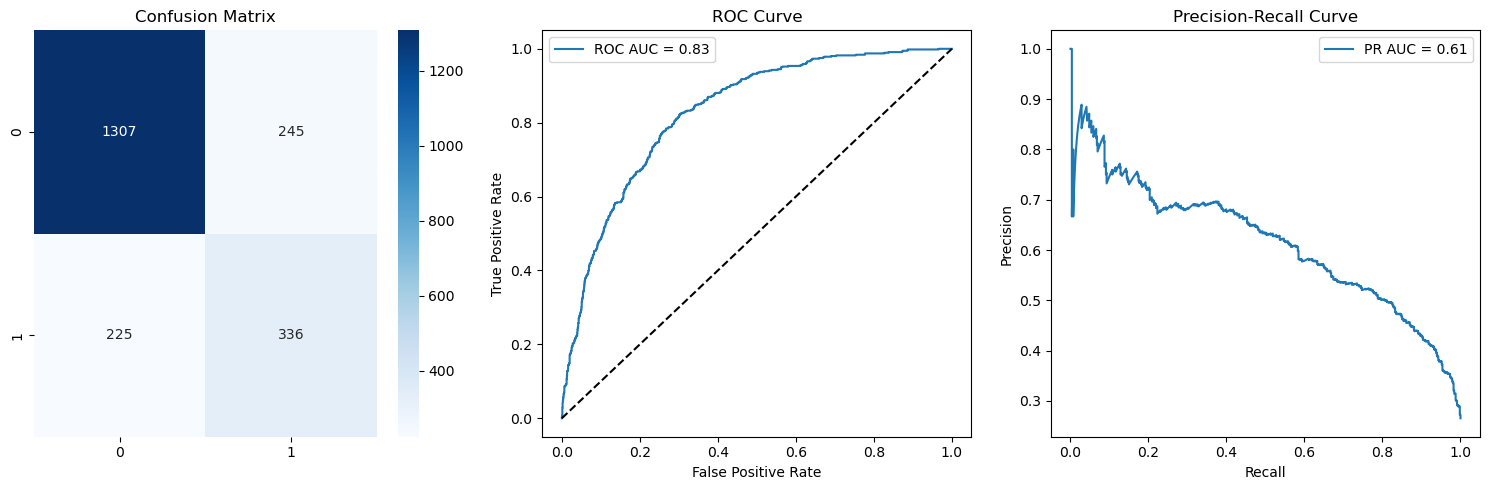

Evaluating CatBoost...


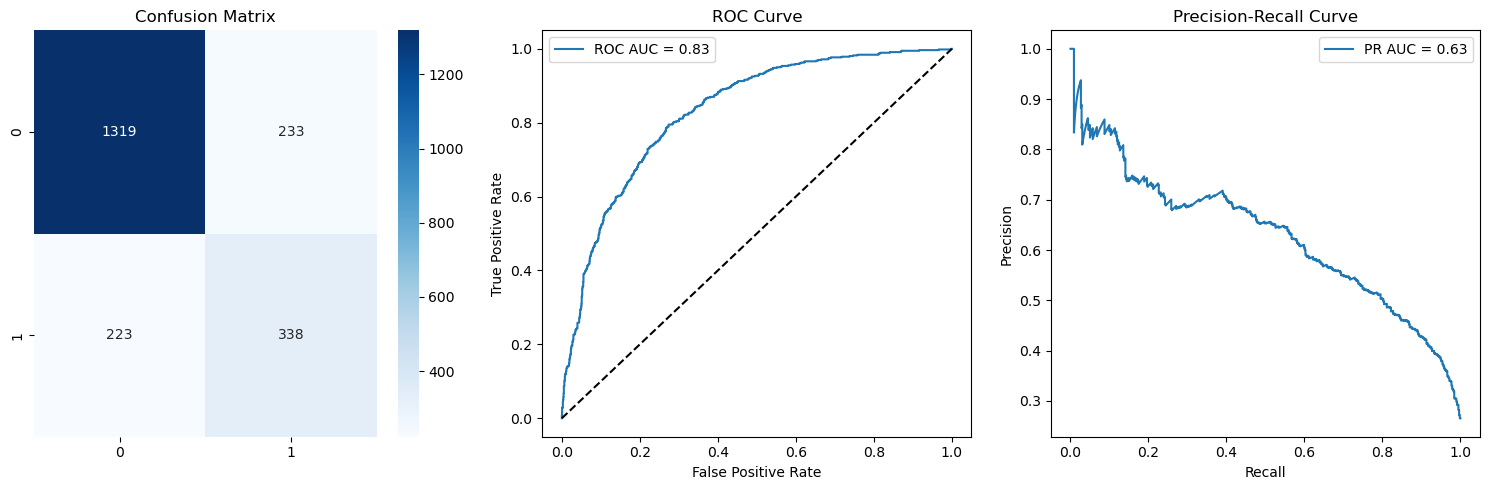

In [103]:
# Оценка базовых моделей
results = {}
for name, model in models.items():
    print(f'Evaluating {name}...')
    results[name] = evaluate_model(model, X_train_res, X_test_preprocessed, y_train_res, y_test)

In [104]:
# Сравнение метрик
metrics_df = pd.DataFrame(results).T
print(metrics_df)

                     accuracy  precision    recall        f1   roc_auc  \
Logistic Regression  0.748699   0.517321  0.798574  0.627891  0.844549   
Random Forest        0.780407   0.587703  0.579323  0.583483  0.814443   
Gradient Boosting    0.777094   0.566568  0.682709  0.619240  0.841195   
XGBoost              0.780880   0.586879  0.590018  0.588444  0.814942   
LightGBM             0.777567   0.578313  0.598930  0.588441  0.828401   
CatBoost             0.784193   0.591944  0.602496  0.597173  0.830886   

                       pr_auc  
Logistic Regression  0.642019  
Random Forest        0.581754  
Gradient Boosting    0.642934  
XGBoost              0.598259  
LightGBM             0.614327  
CatBoost             0.628421  


<Figure size 1200x800 with 0 Axes>

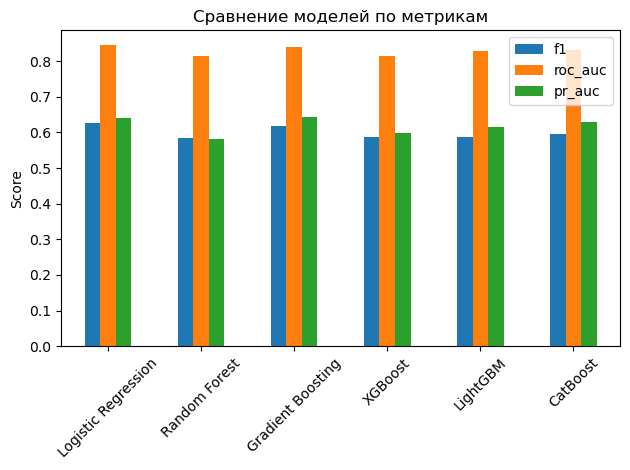

In [105]:
# Визуализация сравнения моделей
plt.figure(figsize=(12, 8))
metrics_df[['f1', 'roc_auc', 'pr_auc']].plot(kind='bar', rot=45)
plt.title('Сравнение моделей по метрикам')
plt.ylabel('Score')
plt.tight_layout()
plt.savefig('models_comparison.png')
plt.show()

In [106]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=UserWarning)
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [107]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'random_state': 42
    }
    
    model = XGBClassifier(**params)
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test_preprocessed)
    return f1_score(y_test, y_pred)

In [108]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

  0%|          | 0/50 [00:00<?, ?it/s]

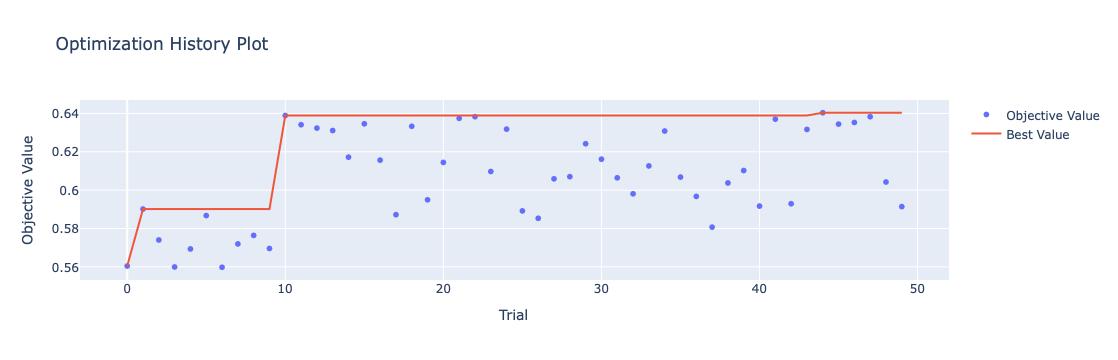

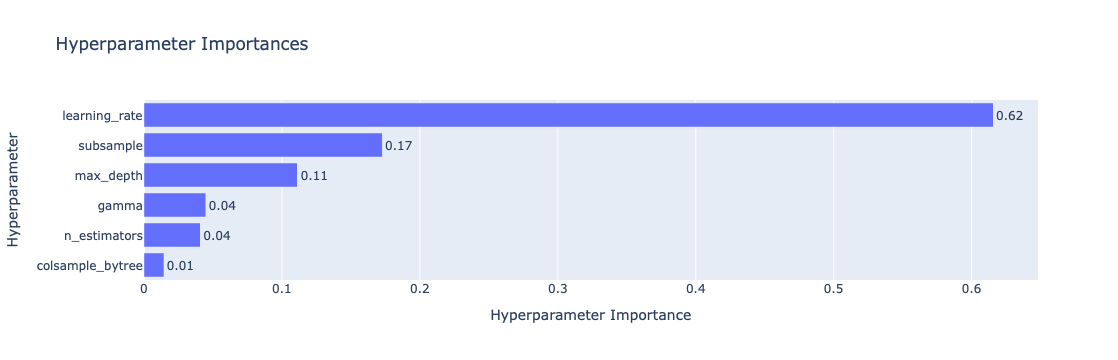

In [109]:
# Визуализация процесса оптимизации
plot_optimization_history(study).show()
plot_param_importances(study).show()

In [110]:
# Лучшие параметры
best_params = study.best_params
print(f'Best parameters: {best_params}')
print(f'Best F1-score: {study.best_value}')

Best parameters: {'learning_rate': 0.012136582208322283, 'max_depth': 4, 'n_estimators': 267, 'gamma': 0.32427902363147965, 'subsample': 0.9910039732423094, 'colsample_bytree': 0.6929309692707979}
Best F1-score: 0.6403641881638846


In [111]:
def objective_lightgbm(trial):
    params = {
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'random_state': 42,
        'verbosity': -1  # убирает вывод
    }
    
    model = LGBMClassifier(**params)
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test_preprocessed)
    return f1_score(y_test, y_pred)

In [112]:
study_lightgbm = optuna.create_study(direction='maximize')
study_lightgbm.optimize(objective_lightgbm, n_trials=50, show_progress_bar=True)

  0%|          | 0/50 [00:00<?, ?it/s]

In [113]:
print('LightGBM Best parameters:', study_lightgbm.best_params)
print('LightGBM Best F1-score:', study_lightgbm.best_value)

LightGBM Best parameters: {'num_leaves': 212, 'max_depth': 3, 'learning_rate': 0.0519546934281014, 'n_estimators': 105, 'min_child_samples': 94, 'subsample': 0.8316549060657655, 'colsample_bytree': 0.7410761944772113, 'reg_alpha': 0.6103923006031213, 'reg_lambda': 0.4066042374118932}
LightGBM Best F1-score: 0.6398176291793313


In [114]:
def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'random_strength': trial.suggest_float('random_strength', 0, 1),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'random_state': 42,
        'verbose': False  # убирает вывод
    }
    
    model = CatBoostClassifier(**params)
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test_preprocessed)
    return f1_score(y_test, y_pred)

In [115]:
study_catboost = optuna.create_study(direction='maximize')
study_catboost.optimize(objective_catboost, n_trials=50, show_progress_bar=True)

  0%|          | 0/50 [00:00<?, ?it/s]

In [116]:
print('CatBoost Best parameters:', study_catboost.best_params)
print('CatBoost Best F1-score:', study_catboost.best_value)

CatBoost Best parameters: {'iterations': 708, 'depth': 3, 'learning_rate': 0.011009714189883342, 'l2_leaf_reg': 8.753786142778264, 'border_count': 245, 'bagging_temperature': 0.43890363806714106, 'random_strength': 0.7217691372678731, 'grow_policy': 'Depthwise'}
CatBoost Best F1-score: 0.6326034063260341


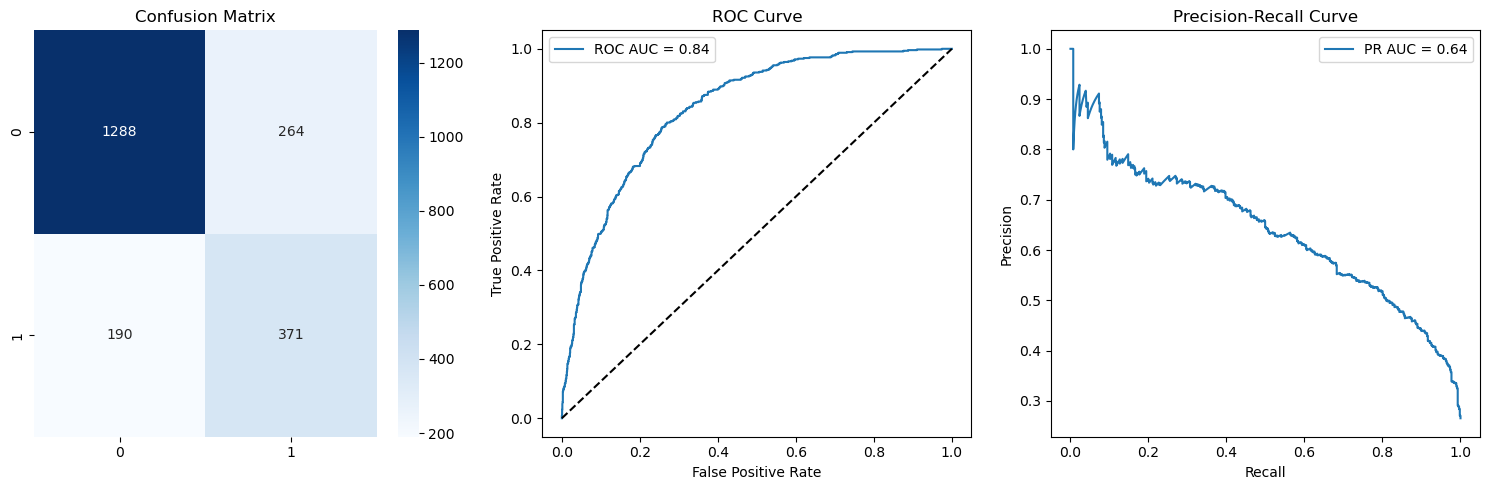

In [117]:
# Создание ансамблевых моделей
# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', optimized_xgb),
        ('lgbm', LGBMClassifier(random_state=42)),
        ('cat', CatBoostClassifier(random_state=42, verbose=0))
    ],
    voting='soft',
    weights=[0.4, 0.3, 0.3]
)

results['Voting Classifier'] = evaluate_model(voting_clf, X_train_res, X_test_preprocessed, y_train_res, y_test)

In [ ]:
# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=[
        ('xgb', optimized_xgb),
        ('lgbm', LGBMClassifier(random_state=42)),
        ('cat', CatBoostClassifier(random_state=42, verbose=0))
    ],
    final_estimator=GradientBoostingClassifier(random_state=42)
)

results['Stacking Classifier'] = evaluate_model(stacking_clf, X_train_res, X_test_preprocessed, y_train_res, y_test)

In [ ]:
# Анализ важности признаков
# Для XGBoost
optimized_xgb.fit(X_train_res, y_train_res)
feature_importance = optimized_xgb.feature_importances_

In [ ]:
# Создание DataFrame для визуализации
importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

In [ ]:
# Визуализация важности признаков
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 важных признаков (XGBoost)')
plt.tight_layout()
plt.savefig('feature_importance_xgb.png')
plt.show()

In [ ]:
# SHAP анализ для интерпретации модели
explainer = shap.TreeExplainer(optimized_xgb)
shap_values = explainer.shap_values(X_train_res)

In [ ]:
# Визуализация SHAP значений
plt.figure()
shap.summary_plot(shap_values, X_train_res, feature_names=all_features, plot_type="bar", max_display=20)
plt.savefig('shap_summary.png')
plt.show()

In [ ]:
plt.figure()
shap.summary_plot(shap_values, X_train_res, feature_names=all_features, max_display=20)
plt.savefig('shap_detailed.png')
plt.show()

In [ ]:
# Анализ парных взаимодействий
# Выберем два наиболее важных признака
top_features = importance_df.head(2)['Feature'].values
idx1 = np.where(all_features == top_features[0])[0][0]
idx2 = np.where(all_features == top_features[1])[0][0]

plt.figure()
shap.dependence_plot(idx1, shap_values, X_train_res, feature_names=all_features, interaction_index=idx2)
plt.savefig('shap_interaction.png')
plt.show()

In [ ]:
# Оптимальный порог классификации по F1-score
y_prob = optimized_xgb.predict_proba(X_test_preprocessed)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_threshold = thresholds[np.argmax(f1_scores)]

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores[:-1], label='F1-score')
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best threshold = {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.title('Оптимальный порог классификации')
plt.legend()
plt.savefig('optimal_threshold.png')
plt.show()

In [ ]:
# Сравнение всех моделей
final_metrics = pd.DataFrame(results).T
print(final_metrics)

In [ ]:
# Визуализация итогового сравнения
plt.figure(figsize=(12, 8))
final_metrics[['f1', 'roc_auc', 'pr_auc']].plot(kind='bar', rot=45)
plt.title('Сравнение всех моделей по метрикам')
plt.ylabel('Score')
plt.tight_layout()
plt.savefig('final_models_comparison.png')
plt.show()